# Prédire la qualité sanitaire d'un établissement alimentaire

Olivier Viollet, avril 2019, olivier.viollet[a]gmail.com

## Résumé

Cette étude apporte aux autorités chargées du contrôle sanitaire des établissements alimentaires un modèle destiné à prédire leur qualité sanitaire. Les meilleurs modèles n'y parviennent qu'avec une efficacité relativement satisfaisante, ce qui indique la nécessité d'inclure d'autres variables explicatives.

Plan :

1. Objectif et données
2. Exploration et transformation des données
3. Modélisation de la qualité sanitaire
4. Evaluation de la modélisation

## 1. Objectif et données

L'objectif de cette étude est de concevoir un modèle permettant aux autorités chargées du contrôle sanitaire des établissements alimentaires de prédire leur qualité sanitaire. Un tel modèle serait avantageux dans la mesure où il permettrait d'inspecter en priorité des établissements dont la qualité prédite serait insuffisante.

Les données proviennent du dispositif d'information "Alim' confiance", dans leur état mis à jour le 27 août 2018. Elles sont accessibles sur le site d'ouverture des données publiques, data.gouv.fr, à l'adresse suivante : https://www.data.gouv.fr/fr/datasets/resultats-des-controles-officiels-sanitaires-dispositif-dinformation-alimconfiance/

Les résultats de **41350 contrôles** sont disponibles. La variable cible est l'appréciation de l'inspection sur la qualité sanitaire de l'établissement, "Synthese_eval_sanit". Pour la prédire, sont mobilisées les variables explicatives suivantes :

- le type d'établissement ;
- son activité ;
- son adresse, y compris son département.

Les données doivent faire l'objet de plusieurs transformations afin d'extraire et de mettre en forme les variables prédictives.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils, to_categorical
from keras import regularizers
from keras import backend as K

from sklearn import metrics

# fonction de recodage
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

Using TensorFlow backend.


In [3]:
    # charger les données
alimentation = pd.read_csv('export_alimconfiance.csv', encoding = "utf-8", sep = ";", usecols = [0,1,3,4,5,6,12])
print(alimentation.info())
alimentation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41350 entries, 0 to 41349
Data columns (total 7 columns):
filtre                                28520 non-null object
APP_Libelle_activite_etablissement    41347 non-null object
ods_adresse                           39746 non-null object
Code_postal                           41350 non-null object
Libelle_commune                       41350 non-null object
Synthese_eval_sanit                   41350 non-null object
ods_type_activite                     41350 non-null object
dtypes: object(7)
memory usage: 2.2+ MB
None


,filtre,APP_Libelle_activite_etablissement,ods_adresse,Code_postal,Libelle_commune,Synthese_eval_sanit,ods_type_activite
0,Libre service,Libre service,229 AV DE LA REPUBLIQUE,93800,Épinay-sur-Seine,Très satisfaisant,Autres
1,Restaurant,Restaurant,2 PLACE DU COMMERCE,51430,Tinqueux,Satisfaisant,Autres
2,Restaurant,Restaurant,11 RUE DE MONTYON,75009,Paris 9e Arrondissement,Satisfaisant,Autres
3,Restauration collective,Restauration collective,40 Av de la Gare,33200,Bordeaux,Très satisfaisant,Autres
4,Restaurant,Restaurant,54 AVENUE DAUMESNIL,75012,Paris 12e Arrondissement,Satisfaisant,Autres


## 2. Exploration et transformation des données

### Variable cible : la qualité sanitaire de l'établissement

Le jeu de données initial distingue quatre classes de niveau sanitaire ; or, seule une poignée d'établissements relève du pire niveau. C'est pourquoi nous choisissons de **fusionner les deux niveaux les moins sains en une même classe**, "à améliorer", ramenant le nombre de classes à trois. 

Malgré cette reclassification, le jeu de données demeure très déséquilibré, la pire classe ne comprenant qu'environ 2500 cas tandis que les deux meilleures, "très satisfaisant" et "satisfaisant", dépassent les 17500 établissements chacun. 

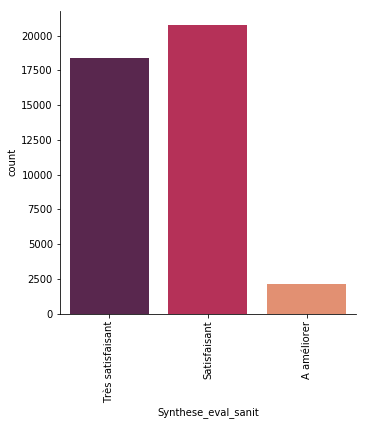

In [4]:
pd.value_counts(alimentation.Synthese_eval_sanit)
alimentation['Synthese_eval_sanit'] = coding(alimentation['Synthese_eval_sanit'], 
                                             {'A corriger de manière urgente':'A améliorer'})
sns.catplot(x = 'Synthese_eval_sanit', 
            kind = 'count', palette="rocket", data = alimentation).set_xticklabels(rotation=90) 

### Variables explicatives 

#### Type d'activité

Deux colonnes du jeu de données initial aident à cerner l'activité de l'établissement ; les fusionner permet de réduire le nombre de valeurs manquantes pour cette variable explicative, dénommée "type" d'activité. Le grand nombre de types d'activité nous conduit à ne conserver que les plus fréquents, les autres étant fusionnés dans une modalité "Autre".

On observe que la qualité sanitaire varie fortement en fonction du type d'activité, même si, pour la plupart des activités, les inspections relèvent un nombre assez proche d'établissements, sauf exceptions (restaurant, produits de la mer et d'eau douce, etc.), appartenant à l'une ou l'autre des deux meilleures classes sanitaires.

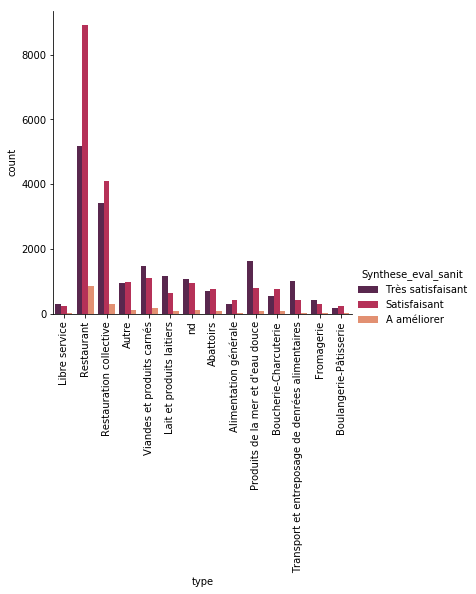

In [5]:
alimentation['ods_type_activite'] = coding(alimentation['ods_type_activite'], {'Autres':''})
alimentation['filtre'].fillna('', inplace = True)
alimentation['type'] = alimentation['filtre'] + alimentation['ods_type_activite']
alimentation['type'] = coding(alimentation['type'], {'':'nd'})
alimentation.drop(columns = ['ods_type_activite','filtre'], inplace=True)
series = pd.value_counts(alimentation['type'])
mask = (series/series.sum() * 100).lt(1)  
alimentation['type'] = np.where(alimentation['type'].isin(series[mask].index),
                                'Autre',alimentation['type'])
sns.catplot(x = 'type', hue = 'Synthese_eval_sanit', 
            kind = 'count', palette="rocket", data = alimentation).set_xticklabels(rotation=90) 

#### Département

Le grand nombre de départements rendrait l'observation graphique des données trop illisible.

In [6]:
alimentation['Code_postal'] = alimentation['Code_postal'].apply('{0:0>5}'.format)
alimentation['Code_postal'] = alimentation['Code_postal'].astype(str).str[:2]
alimentation['Code_postal'] = coding(alimentation['Code_postal'], {'99':'00'})

#### Nature et activité de l'établissement

A partir de la colonne rapportant le libellé de l'activité de l'établissement, est créée une variable permettant de savoir si celui-ci est un rayon d'un établissement qui l'englobe. On observe néanmoins que cette variable risque de s'avérer peu utile car les proportions entre classes selon que l'établissement est un rayon ou non n'apparaissent pas très différentes des proportions des classes du jeu de données dans son ensemble.

Par ailleurs, tenant compte du grand nombre d'activités possibles du jeu de données, la cardinalité de la variable est réduite pour ne conserver que les occurrences les plus fréquentes. L'observation graphique du résultat semble indiquer que cette variable sera utile à la modélisation car les proportions entre classes selon l'activité apparaissent sensiblement différentes.

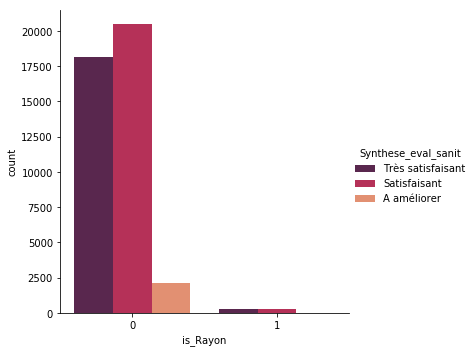

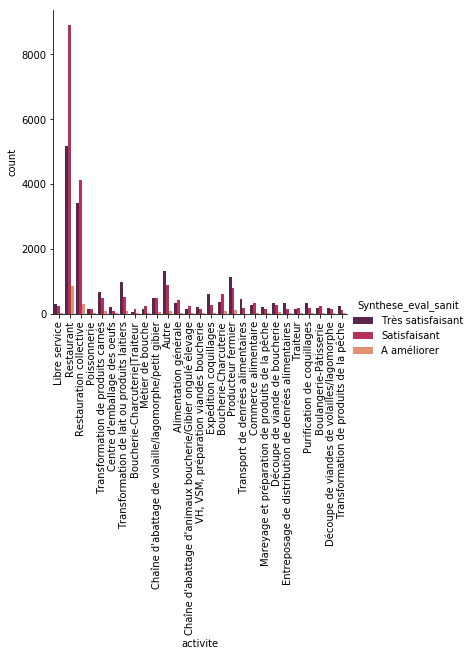

In [7]:
pd.value_counts(alimentation.APP_Libelle_activite_etablissement)
alimentation['APP_Libelle_activite_etablissement'].fillna('nd', inplace = True)

    # is Rayon
alimentation['is_Rayon'] = alimentation['APP_Libelle_activite_etablissement'].str.count('Rayon')
alimentation["is_Rayon"] = coding(alimentation["is_Rayon"], {2: 1, 3:1, 4:1, 5:1}) 
sns.catplot(x="is_Rayon", hue = "Synthese_eval_sanit", 
            kind="count", palette="rocket", data=alimentation)

    # réduire la cardinalité
series = pd.value_counts(alimentation.APP_Libelle_activite_etablissement)
mask = (series/series.sum() * 100).lt(0.5)
alimentation['activite'] = np.where(alimentation['APP_Libelle_activite_etablissement'].isin(series[mask].index),
                                    'Autre',alimentation['APP_Libelle_activite_etablissement'])
alimentation.drop(columns = ['APP_Libelle_activite_etablissement'], inplace=True)
sns.catplot(x="activite", hue = "Synthese_eval_sanit", 
            kind="count", palette="rocket", data=alimentation).set_xticklabels(rotation=90) 

#### Adresse de l'établissement

A partir de l'adresse de l'établissement, nous créons plusieurs variables binaires afin de savoir si ce dernier se situe sur une avenue, une rue, une place, un chemin, un boulevard. Cependant, la visualisation des données nous amène à douter de la pertinence de ces nouvelles variables explicatives dans la mesure où les proportions entre classes n'apparaissent pas très différentes en fonction de la localisation urbaine par rapport aux proportions du jeu de données dans son ensemble. 

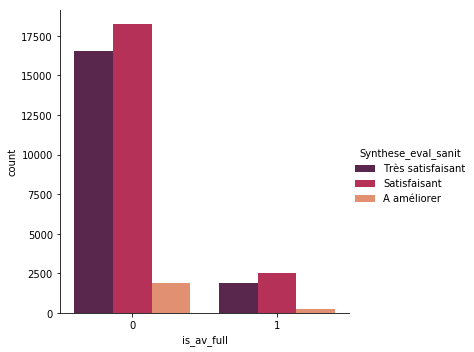

In [8]:
alimentation['ods_adresse'] = alimentation['ods_adresse'].str.upper()
alimentation['ods_adresse'].fillna('nd', inplace = True)
alimentation['is_avenue'] = alimentation['ods_adresse'].str.count('AVENUE')
alimentation['is_av'] = alimentation['ods_adresse'].str.count('AV')
alimentation['is_av'] = coding(alimentation['is_av'], {2:1})
alimentation['is_av_full'] = alimentation['is_avenue'] + alimentation['is_av']
alimentation['is_av_full'] = coding(alimentation['is_av_full'], {2:1})
alimentation.drop(columns = ['is_av','is_avenue'], inplace=True)
sns.catplot(x="is_av_full", hue = "Synthese_eval_sanit", 
            kind="count", palette="rocket", data=alimentation)

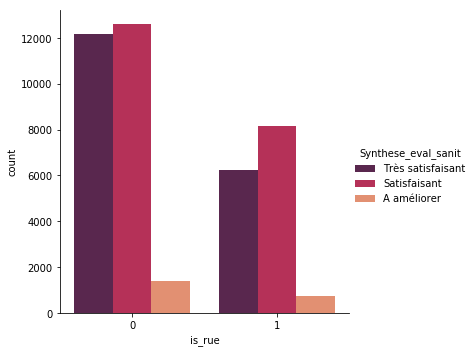

In [9]:
alimentation['is_rue'] = alimentation['ods_adresse'].str.count('RUE')
alimentation['is_rue'] = coding(alimentation['is_rue'], {2:1})
sns.catplot(x="is_rue", hue = "Synthese_eval_sanit", 
            kind="count", palette="rocket", data=alimentation)

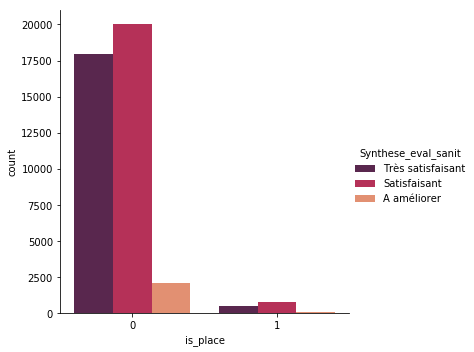

In [10]:
alimentation['is_place'] = alimentation['ods_adresse'].str.count('PLACE')
sns.catplot(x="is_place", hue = "Synthese_eval_sanit", 
            kind="count", palette="rocket", data=alimentation)

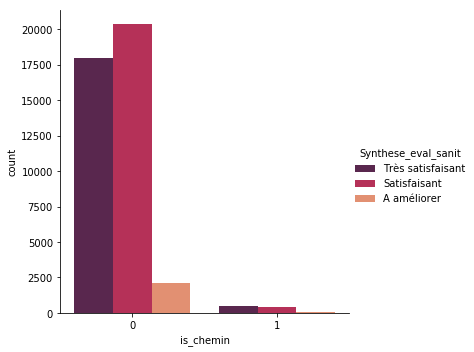

In [11]:
alimentation['is_chemin'] = alimentation['ods_adresse'].str.count('CHEMIN')
sns.catplot(x="is_chemin", hue = "Synthese_eval_sanit", 
            kind="count", palette="rocket", data=alimentation)

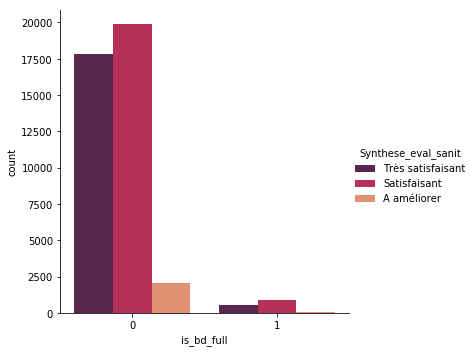

In [12]:
alimentation['is_boulevard'] = alimentation['ods_adresse'].str.count('BOULEVARD')
alimentation['is_bd'] = alimentation['ods_adresse'].str.count('BD')
alimentation['is_bd_full'] = alimentation['is_boulevard'] + alimentation['is_bd']
alimentation['is_bd_full'] = coding(alimentation['is_bd_full'], {2:1})
alimentation.drop(columns = ['is_bd','is_boulevard'], inplace=True)
sns.catplot(x="is_bd_full", hue = "Synthese_eval_sanit",
            kind="count", palette="rocket", data=alimentation)

In [13]:
alimentation.drop(columns = ['ods_adresse','Libelle_commune'], inplace=True)
alimentation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41350 entries, 0 to 41349
Data columns (total 10 columns):
Code_postal            41350 non-null object
Synthese_eval_sanit    41350 non-null object
type                   41350 non-null object
is_Rayon               41350 non-null int64
activite               41350 non-null object
is_av_full             41350 non-null int64
is_rue                 41350 non-null int64
is_place               41350 non-null int64
is_chemin              41350 non-null int64
is_bd_full             41350 non-null int64
dtypes: int64(6), object(4)
memory usage: 3.2+ MB


## 3. Modélisation de la qualité sanitaire

### Mesure de performance

Le problème relève de la **classification**, puisque les modèles devront prédire de quelle classe sanitaire relève un établissement, avec trois possibilités : "très satisfaisant", "satisfaisant" et "à améliorer".

Deux mesures de performance devraient être retenues : 
- d'une part, le **taux de classifications justes** ; 
- d'autre part, le taux d'établissements relevant de la pire classe, "à améliorer", qui ont été identifiés comme tels, autrement dit le ***recall*** de cette classe. 

### Jeux de données

Des **variables binaires** sont obtenues à partir des variables catégoriques. Puis, **trois jeux de données** sont créés à partir du jeu de données initial : d'abord un jeu d'entrainement et un jeu de test, puis un jeu de validation est extrait du premier. Les modèles sont construits sur le jeu d'entrainement, et leurs hyperparamètres ajustés sur le jeu de validation - sauf exception. Ce n'est que dans la partie 4. que nous pourrons jauger, grâce au jeu de test, de leur faculté à se généraliser.

A noter que les valeurs sont transformées à l'aide de la technique **SMOTE** (Synthetic Minority Over-sampling Technique) afin d'équilibrer les trois classes dans le jeu d'entrainement. 

In [14]:
# préparer les jeux de données
    # variable cible
Target = alimentation['Synthese_eval_sanit']
alimentation.drop(columns = ['Synthese_eval_sanit'], inplace=True)

    # variables binaires
predictors = pd.get_dummies(alimentation)

    # jeux d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

    # jeux d'entrainement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state=42)

    # SMOTE
pd.value_counts(y_train)
smote = SMOTE('all', random_state = 2) 
X_train_res, y_train = smote.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train_res, columns = X_train.columns)
del X_train_res

### Régression logistique

55 % des prédictions de la régression logistique sont justes ; toutefois, seuls 16 % des établissements dont la qualité sanitaire est "à améliorer" ont été identifiés, ce qui est peu.

In [15]:
# régression logistique
lr = LogisticRegression()
parameters = {'C': np.linspace(1, 20, 10)}
clf = GridSearchCV(lr, parameters, cv=3, verbose=0, n_jobs=-1)
clf.fit(X_train, y_train.ravel())
clf.best_params_ # 20

{'C': 20.0}

In [17]:
lr_def = LogisticRegression(C = 20, penalty = 'l2', verbose=0)
lr_def.fit(X_train, y_train)
y_pred_train = lr_def.predict(X_train)
y_pred_val = lr_def.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 61.4
print("Taux de classifications exactes sur le jeu de validation :", 
      metrics.accuracy_score(y_val, y_pred_val)) # 54.7
print(metrics.classification_report(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.6137062232300328
Taux de classifications exactes sur le jeu de validation : 0.5471584038694075
                   precision    recall  f1-score   support

      A améliorer       0.09      0.16      0.11       351
     Satisfaisant       0.61      0.56      0.58      3308
Très satisfaisant       0.59      0.58      0.58      2957

        micro avg       0.55      0.55      0.55      6616
        macro avg       0.43      0.43      0.43      6616
     weighted avg       0.57      0.55      0.56      6616



### Forêt aléatoire

La forêt aléatoire régularisée parvient à un taux de classifications justes analogue à la régression logistique (54 %) et identifie un quart des établissements dont la qualité sanitaire doit être améliorée.

In [18]:
# forêt aléatoire
forest = RandomForestClassifier(criterion='entropy', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_val = forest.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 70.5
print("Taux de classifications exactes sur le jeu de validation :", 
      metrics.accuracy_score(y_val, y_pred_val)) # 51.5
print(metrics.classification_report(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.7054169816074578
Taux de classifications exactes sur le jeu de validation : 0.5155683192261185
                   precision    recall  f1-score   support

      A améliorer       0.10      0.31      0.15       351
     Satisfaisant       0.59      0.53      0.56      3308
Très satisfaisant       0.60      0.52      0.56      2957

        micro avg       0.52      0.52      0.52      6616
        macro avg       0.43      0.45      0.42      6616
     weighted avg       0.57      0.52      0.54      6616



In [19]:
forest = RandomForestClassifier(criterion='entropy', 
                                random_state=1, 
                                n_jobs=-1, 
                                min_samples_split = 60,
                                max_features = .6) 
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_val = forest.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 66.4
print("Taux de classifications exactes sur le jeu de validation :", 
      metrics.accuracy_score(y_val, y_pred_val)) # 54.4
print(metrics.classification_report(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.6647770219198791
Taux de classifications exactes sur le jeu de validation : 0.5444377267230955
                   precision    recall  f1-score   support

      A améliorer       0.10      0.24      0.14       351
     Satisfaisant       0.61      0.56      0.58      3308
Très satisfaisant       0.61      0.56      0.58      2957

        micro avg       0.54      0.54      0.54      6616
        macro avg       0.44      0.45      0.44      6616
     weighted avg       0.58      0.54      0.56      6616



### SVM

Si le *support vector machine* parvient à un meilleur taux global de classifications justes (58 %), il n'identifie guère plus d'établissements dont la qualité sanitaire doit être améliorée que la régression logistique.

In [20]:
# SVM
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)
print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 61.7
print("Taux de classifications exactes sur le jeu de validation:", 
      metrics.accuracy_score(y_val, y_pred_val)) # 58.0
print(metrics.classification_report(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.61708238851096
Taux de classifications exactes sur le jeu de validation: 0.5801088270858524
                   precision    recall  f1-score   support

      A améliorer       0.12      0.17      0.14       351
     Satisfaisant       0.63      0.60      0.61      3308
Très satisfaisant       0.61      0.61      0.61      2957

        micro avg       0.58      0.58      0.58      6616
        macro avg       0.45      0.46      0.45      6616
     weighted avg       0.59      0.58      0.59      6616



### XGboost

Régularisé, le modèle XGboost réalise moins de prédictions justes que les autres algorithmes (50 %) mais il repère 40 % des établissements dont la qualité sanitaire est "à améliorer".

In [21]:
y_train = pd.DataFrame(y_train)
y_train[0] = coding(y_train[0], {'A améliorer': 0, 'Satisfaisant':1,'Très satisfaisant':2}) 
xg_train = xgb.DMatrix(X_train, label= y_train.values)

y_val = pd.DataFrame(y_val)
y_val["Synthese_eval_sanit"] = coding(y_val["Synthese_eval_sanit"], 
                                      {'A améliorer': 0, 'Satisfaisant':1,'Très satisfaisant':2}) 
xg_validation = xgb.DMatrix(X_val)

In [22]:
params = {
    "eta": 0.2,
    "max_depth":12,
    "objective": "multi:softmax",
    "silent": 1,
    'n_estimators': 40,
    "eval_metric": "merror",
    'num_class' : 3}

model = xgb.train(params, xg_train, 30)

y_pred_train = model.predict(xg_train)
y_pred_val = model.predict(xg_validation)

print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 63.2
print("Taux de classifications exactes sur le jeu de validation:", 
      metrics.accuracy_score(y_val, y_pred_val)) # 49.6
print(metrics.classification_report(y_val, y_pred_val))

Taux de classifications exactes sur le jeu d'entrainement : 0.6321995464852608
Taux de classifications exactes sur le jeu de validation: 0.4960701330108827
              precision    recall  f1-score   support

           0       0.09      0.40      0.14       351
           1       0.63      0.49      0.55      3308
           2       0.63      0.51      0.57      2957

   micro avg       0.50      0.50      0.50      6616
   macro avg       0.45      0.47      0.42      6616
weighted avg       0.60      0.50      0.54      6616



### Réseau de neurones

Le réseau de neurones régularisé réussit 55 % de ses prédictions et identifie un établissement sur cinq parmi ceux dont la qualité sanitaire doit être améliorée.

In [23]:
dummy_y_train = to_categorical(y_train)
dummy_y_val = to_categorical(y_val)

In [24]:
model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, dummy_y_train, epochs=50, validation_data = (X_val, dummy_y_val), verbose=1)
y_pred_val = model.predict_classes(X_val) # 54.6
print(metrics.classification_report(y_val, y_pred_val))
K.clear_session()

Train on 39690 samples, validate on 6616 samples
Epoch 1/50
39690/39690 [==============================] - 3s 70us/step - loss: 1.0657 - acc: 0.4182 - val_loss: 1.0227 - val_acc: 0.4255
Epoch 2/50
39690/39690 [==============================] - 1s 24us/step - loss: 0.9359 - acc: 0.5412 - val_loss: 0.9462 - val_acc: 0.5281
Epoch 3/50
39690/39690 [==============================] - 1s 24us/step - loss: 0.8920 - acc: 0.5634 - val_loss: 0.9393 - val_acc: 0.5473
Epoch 4/50
39690/39690 [==============================] - 1s 25us/step - loss: 0.8711 - acc: 0.5737 - val_loss: 0.9624 - val_acc: 0.5148
Epoch 5/50
39690/39690 [==============================] - 1s 25us/step - loss: 0.8656 - acc: 0.5769 - val_loss: 0.9217 - val_acc: 0.5434
Epoch 6/50
39690/39690 [==============================] - 1s 25us/step - loss: 0.8571 - acc: 0.5791 - val_loss: 0.9528 - val_acc: 0.5307
Epoch 7/50
39690/39690 [==============================] - 1s 25us/step - loss: 0.8539 - acc: 0.5858 - val_loss: 0.9323 - val_acc:

## 4. Evaluer la modélisation

Les jeux d'entrainement et de test sont recréés. Le jeu d'entrainement est transformé à l'aide du SMOTE afin d'équilibrer les trois classes sanitaires en son sein. Les modèles sont entrainés une ultime fois sur les jeux d'entrainement à l'aide des hyperparamètres trouvés sur le jeu de validation dans la partie précédente, puis évalués sur le jeu de test.

Nous recommandons le recours au **modèle XGboost**. En effet, si son **taux de classifications justes** sur le jeu de test est certes le plus faible de tous les modèles (51 %), cette faiblesse ne consiste qu'en quelques points de pourcentage d'écart. Surtout, ce modèle s'avère, de loin, le meilleur pour identifier comme tels les **établissements les moins sains** : **44 %** des établissements dont la qualité sanitaire est "à améliorer" ont bien été repérés ainsi. Ces résultats sont cohérents avec ceux obtenus sur le jeu de validation.

Cependant, il convient de noter que, sur 100 établissements pour lesquels XGboost prédirait "à améliorer", seuls 9 correspondraient effectivement à cette classe. Cette faible ***precision*** nous indique que d'autres variables explicatives sont nécessaires pour améliorer la force prédictive des algorithmes.

In [25]:
# re-créer le jeu d'entrainement et le jeu de test
X_train, X_test, y_train, y_test = train_test_split(predictors, Target, test_size=0.2, random_state=15)

# SMOTE
pd.value_counts(y_train)
smote = SMOTE('all', random_state = 2) 
X_train_res, y_train = smote.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train_res, columns = X_train.columns)
del X_train_res

### Régression logistique

In [26]:
# régression logistique
lr_def = LogisticRegression(C = 20, penalty = 'l2', verbose=0)
lr_def.fit(X_train, y_train)
y_pred_train = lr_def.predict(X_train)
y_pred_test = lr_def.predict(X_test)
print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 60.2
print("Taux de classifications exactes sur le jeu de test :", 
      metrics.accuracy_score(y_test, y_pred_test)) # 55.7
print(metrics.classification_report(y_test, y_pred_test))

Taux de classifications exactes sur le jeu d'entrainement : 0.6016245414600717
Taux de classifications exactes sur le jeu de test : 0.5570737605804111
                   precision    recall  f1-score   support

      A améliorer       0.10      0.22      0.14       413
     Satisfaisant       0.63      0.57      0.60      4222
Très satisfaisant       0.60      0.58      0.59      3635

        micro avg       0.56      0.56      0.56      8270
        macro avg       0.44      0.46      0.44      8270
     weighted avg       0.59      0.56      0.57      8270



### Forêt aléatoire

In [27]:
# forêt aléatoire
forest = RandomForestClassifier(criterion='entropy', 
                                random_state=1, 
                                n_jobs=-1, 
                                min_samples_split = 60,
                                max_features = .6) 
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)
print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 65.3
print("Taux de classifications exactes sur le jeu de test :", 
      metrics.accuracy_score(y_test, y_pred_test)) # 55.0
print(metrics.classification_report(y_test, y_pred_test))

Taux de classifications exactes sur le jeu d'entrainement : 0.6533841254484621
Taux de classifications exactes sur le jeu de test : 0.5500604594921402
                   precision    recall  f1-score   support

      A améliorer       0.09      0.26      0.14       413
     Satisfaisant       0.63      0.57      0.60      4222
Très satisfaisant       0.61      0.56      0.58      3635

        micro avg       0.55      0.55      0.55      8270
        macro avg       0.45      0.46      0.44      8270
     weighted avg       0.60      0.55      0.57      8270



### SVM

In [28]:
# SVM
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 60.9
print("Taux de classifications exactes sur le jeu de test:", 
      metrics.accuracy_score(y_test, y_pred_test)) # 57.6
print(metrics.classification_report(y_test, y_pred_test))

Taux de classifications exactes sur le jeu d'entrainement : 0.6095053815455315
Taux de classifications exactes sur le jeu de test: 0.575695284159613
                   precision    recall  f1-score   support

      A améliorer       0.12      0.23      0.16       413
     Satisfaisant       0.64      0.59      0.61      4222
Très satisfaisant       0.61      0.60      0.60      3635

        micro avg       0.58      0.58      0.58      8270
        macro avg       0.46      0.47      0.46      8270
     weighted avg       0.60      0.58      0.59      8270



### XGboost

In [29]:
y_train = pd.DataFrame(y_train)
y_train[0] = coding(y_train[0], {'A améliorer': 0, 'Satisfaisant':1,'Très satisfaisant':2}) 
xg_train = xgb.DMatrix(X_train, label= y_train.values)

y_test = pd.DataFrame(y_test)
y_test["Synthese_eval_sanit"] = coding(y_test["Synthese_eval_sanit"], 
                                      {'A améliorer': 0, 'Satisfaisant':1,'Très satisfaisant':2}) 
xg_test = xgb.DMatrix(X_test)

In [30]:
params = {
    "eta": 0.2,
    "max_depth":12,
    "objective": "multi:softmax",
    "silent": 1,
    'n_estimators': 40,
    "eval_metric": "merror",
    'num_class' : 3}

model = xgb.train(params, xg_train, 30)

y_pred_train = model.predict(xg_train)
y_pred_test = model.predict(xg_test)

print("Taux de classifications exactes sur le jeu d\'entrainement :", 
      metrics.accuracy_score(y_train, y_pred_train)) # 62.1
print("Taux de classifications exactes sur le jeu de test:", 
      metrics.accuracy_score(y_test, y_pred_test)) # 50.8
print(metrics.classification_report(y_test, y_pred_test))

Taux de classifications exactes sur le jeu d'entrainement : 0.6213971862780667
Taux de classifications exactes sur le jeu de test: 0.5079806529625152
              precision    recall  f1-score   support

           0       0.09      0.44      0.15       413
           1       0.65      0.50      0.56      4222
           2       0.64      0.53      0.58      3635

   micro avg       0.51      0.51      0.51      8270
   macro avg       0.46      0.49      0.43      8270
weighted avg       0.62      0.51      0.55      8270



### Réseau de neurones

In [31]:
dummy_y_train = to_categorical(y_train)
dummy_y_test = to_categorical(y_test)

In [32]:
model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, dummy_y_train, epochs=50, verbose=0)
y_pred_test = model.predict_classes(X_test) 
print("Taux de classifications exactes sur le jeu de test:", 
      metrics.accuracy_score(y_test, y_pred_test)) # 54
print(metrics.classification_report(y_test, y_pred_test))
K.clear_session()

Taux de classifications exactes sur le jeu de test: 0.5399032648125756
              precision    recall  f1-score   support

           0       0.09      0.27      0.14       413
           1       0.61      0.59      0.60      4222
           2       0.62      0.52      0.57      3635

   micro avg       0.54      0.54      0.54      8270
   macro avg       0.44      0.46      0.43      8270
weighted avg       0.59      0.54      0.56      8270

